In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 10
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# True function is sin( 2*pi*(x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (2 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.WLSHKernel(
            num_samples=256, ard_num_dims=2, num_dims=2,
        ))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 100 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_cholesky_size(0):
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   os: %.3f    noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item(),
            model.covar_module.outputscale.item(),
            model.likelihood.noise.item()
        ))
        optimizer.step()

20
Iter 1/50 - Loss: 1.125   lengthscale: 0.693   os: 0.693    noise: 0.693
20
Iter 2/50 - Loss: 1.124   lengthscale: 0.694   os: 0.644    noise: 0.644
20
Iter 3/50 - Loss: 1.091   lengthscale: 0.670   os: 0.598    noise: 0.599
20
Iter 4/50 - Loss: 1.099   lengthscale: 0.634   os: 0.560    noise: 0.556
20
Iter 5/50 - Loss: 1.102   lengthscale: 0.596   os: 0.524    noise: 0.516
20
Iter 6/50 - Loss: 1.078   lengthscale: 0.560   os: 0.491    noise: 0.481
20
Iter 7/50 - Loss: 1.072   lengthscale: 0.523   os: 0.476    noise: 0.449
20
Iter 8/50 - Loss: 1.062   lengthscale: 0.487   os: 0.478    noise: 0.421
20
Iter 9/50 - Loss: 1.056   lengthscale: 0.452   os: 0.493    noise: 0.397
20
Iter 10/50 - Loss: 1.040   lengthscale: 0.418   os: 0.517    noise: 0.377
20
Iter 11/50 - Loss: 1.014   lengthscale: 0.387   os: 0.546    noise: 0.359
20
Iter 12/50 - Loss: 0.995   lengthscale: 0.357   os: 0.580    noise: 0.341
20
Iter 13/50 - Loss: 0.957   lengthscale: 0.329   os: 0.619    noise: 0.324
20
Iter 

In [5]:
model.eval()
with gpytorch.settings.prior_mode(), gpytorch.settings.max_cholesky_size(0):
    print(model(train_x).covariance_matrix)

tensor([[4.9059e-01, 4.1849e-01, 3.0959e-01,  ..., 6.3372e-04, 4.1034e-04,
         3.0468e-04],
        [4.1849e-01, 5.1621e-01, 4.4812e-01,  ..., 1.1557e-03, 8.1383e-04,
         6.4520e-04],
        [3.0959e-01, 4.4812e-01, 5.2416e-01,  ..., 1.4005e-03, 1.0106e-03,
         8.0546e-04],
        ...,
        [6.3372e-04, 1.1557e-03, 1.4005e-03,  ..., 5.6856e-01, 4.9206e-01,
         3.5599e-01],
        [4.1034e-04, 8.1383e-04, 1.0106e-03,  ..., 4.9206e-01, 5.9348e-01,
         4.9424e-01],
        [3.0468e-04, 6.4520e-04, 8.0546e-04,  ..., 3.5599e-01, 4.9424e-01,
         5.6692e-01]], grad_fn=<SumBackward1>)


/home/gpleiss/workspace/gpytorch/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


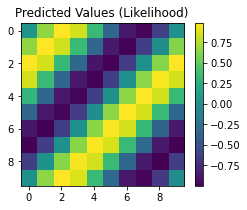

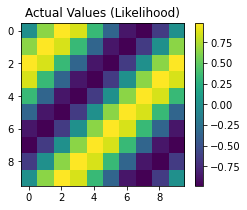

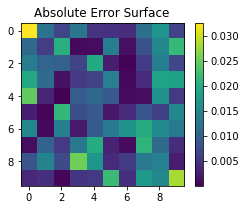

In [6]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        test_x[i * n + j][0] = float(i) / (n-1)
        test_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (2 * math.pi))).view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    if smoke_test: return  # this is for running the notebook in our testing framework
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')